In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import scipy.stats as stats
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load data

In [16]:
folder_path = 'Data'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

run_df = pd.DataFrame()
walk_df = pd.DataFrame()
jump_df = pd.DataFrame()
still_df = pd.DataFrame()
multi_df = pd.DataFrame()

#We have at least 5 motion labels
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    if 'Run' in file:
        temp_df = pd.read_csv(file_path)
        run_df = pd.concat([run_df, temp_df], ignore_index=True)
    elif 'Walk' in file:
        temp_df = pd.read_csv(file_path)
        walk_df = pd.concat([walk_df, temp_df], ignore_index=True)
    elif 'Jump' in file:
        temp_df = pd.read_csv(file_path)
        jump_df = pd.concat([jump_df, temp_df], ignore_index=True)
    elif 'Still' in file:
        temp_df = pd.read_csv(file_path)
        still_df = pd.concat([still_df, temp_df], ignore_index=True)
    elif 'Multi' in file:
        temp_df = pd.read_csv(file_path)
        multi_df = pd.concat([multi_df, temp_df], ignore_index=True)


## Plotting

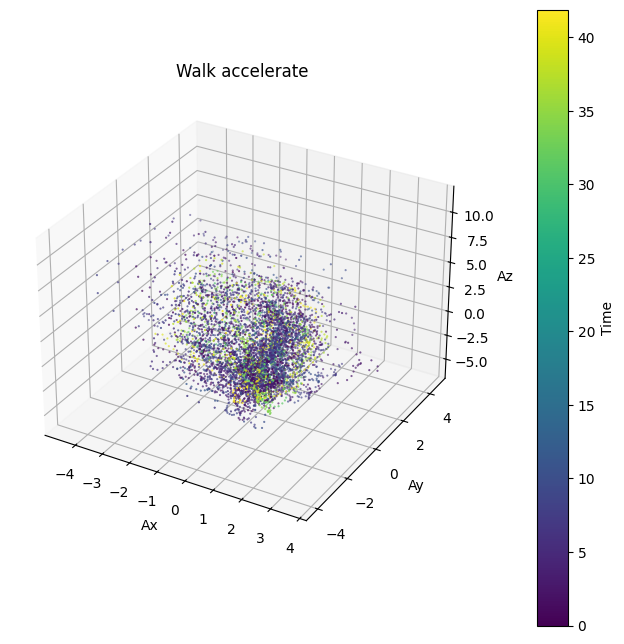

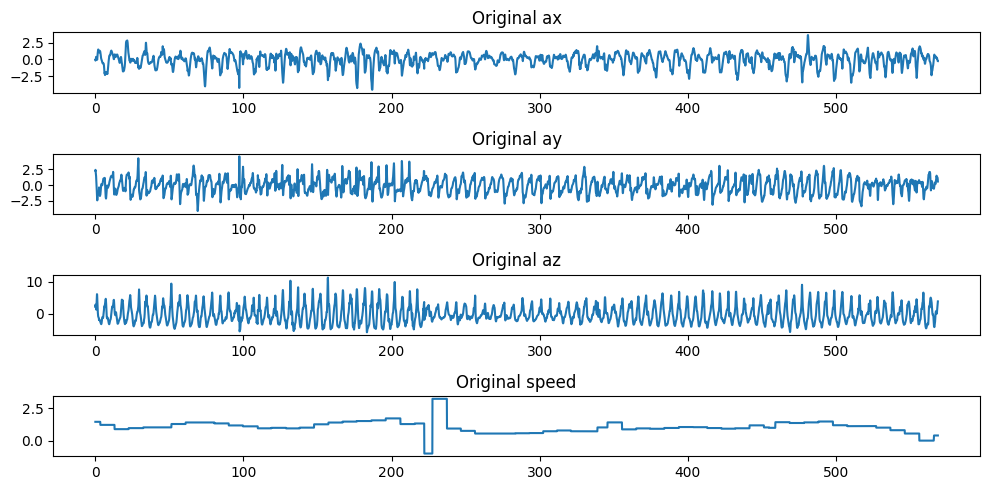

In [17]:

fig1 = plt.figure(figsize=(8, 8))
ax = fig1.add_subplot(111, projection='3d')

sc1 = ax.scatter(walk_df['ax'], walk_df['ay'], walk_df['az'], c=walk_df['time'], cmap='viridis',marker='o', s=0.3)

cbar = plt.colorbar(sc1, ax=ax, pad=0.1)
cbar.set_label('Time')

ax.set_title('Walk accelerate')
ax.set_xlabel('Ax')
ax.set_ylabel('Ay')
ax.set_zlabel('Az')

plt.show(fig1)


plt.figure(figsize=(10, 5))
selected_columns = walk_df.columns[1:5]
selected_data = walk_df[selected_columns]
x = np.arange(0, len(selected_data) * 0.1, 0.1)

for i, col in enumerate(walk_df.columns[1:5]):
    plt.subplot(4, 1, i+1)
    plt.plot(x, walk_df[col],marker='', linestyle='-')
    plt.title(f'{col}')
    
plt.suptitle('Walk Overview', fontsize=16)
plt.tight_layout()
plt.show()

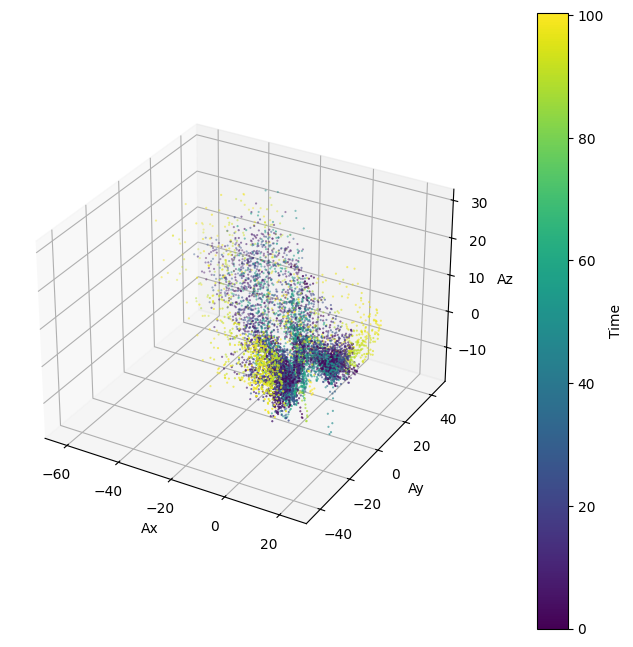

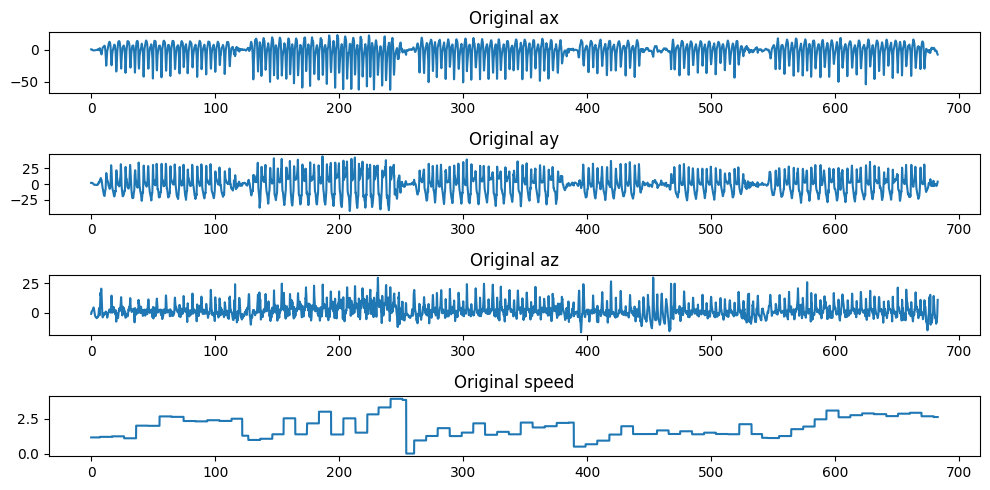

In [18]:
fig2 = plt.figure(figsize=(8, 8))
ax = fig2.add_subplot(111, projection='3d')

sc2 = ax.scatter(run_df['ax'], run_df['ay'], run_df['az'], c=run_df['time'], cmap='viridis',marker='o', s = 0.3)

cbar = plt.colorbar(sc2, ax=ax, pad=0.1)
cbar.set_label('Time')

ax.set_xlabel('Ax')
ax.set_ylabel('Ay')
ax.set_zlabel('Az')

plt.show(fig2)

plt.figure(figsize=(10, 5))
selected_columns = run_df.columns[1:5]
selected_data = run_df[selected_columns]
x = np.arange(0, len(selected_data) * 0.1, 0.1)

for i, col in enumerate(run_df.columns[1:5]):
    plt.subplot(4, 1, i+1)
    plt.plot(x, run_df[col],marker='', linestyle='-')
    plt.title(f'{col}')

plt.suptitle('Run Overview', fontsize=16)
plt.tight_layout()
plt.show()

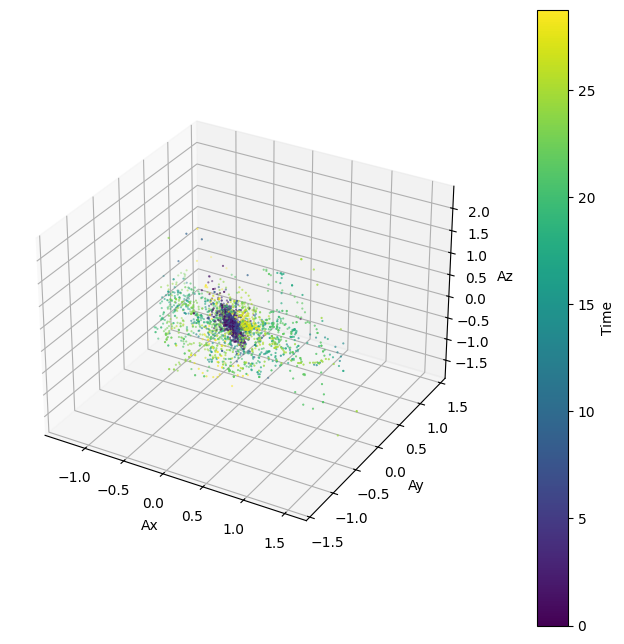

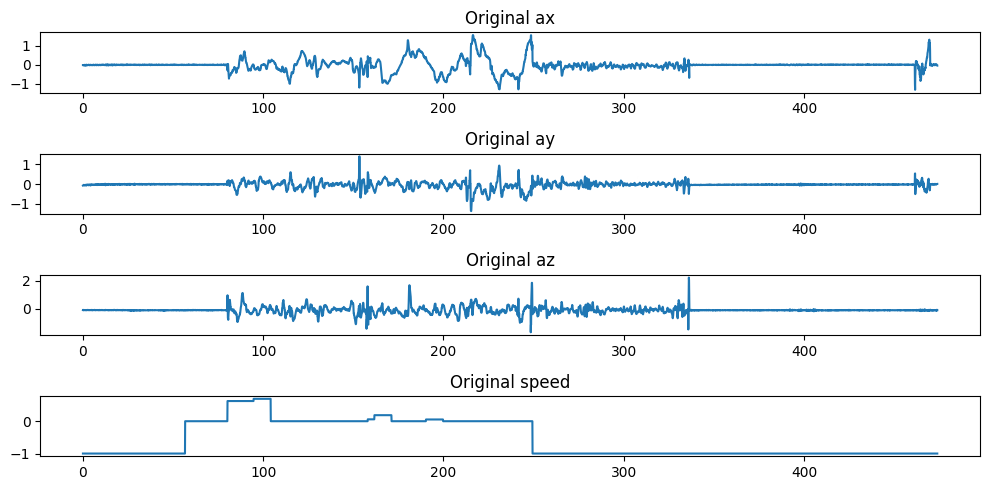

In [19]:
fig3 = plt.figure(figsize=(8, 8))
ax = fig3.add_subplot(111, projection='3d')

sc3 = ax.scatter(still_df['ax'], still_df['ay'], still_df['az'], c=still_df['time'], cmap='viridis',marker='o', s = 0.3)

cbar = plt.colorbar(sc3, ax=ax, pad=0.1)
cbar.set_label('Time')

ax.set_xlabel('Ax')
ax.set_ylabel('Ay')
ax.set_zlabel('Az')

plt.show(fig3)


plt.figure(figsize=(10, 5))
selected_columns =still_df.columns[1:5]
selected_data = still_df[selected_columns]
x = np.arange(0, len(selected_data) * 0.1, 0.1)

for i, col in enumerate(still_df.columns[1:5]):
    plt.subplot(4, 1, i+1)
    plt.plot(x, still_df[col],marker='', linestyle='-')
    plt.title(f'{col}')
    
plt.suptitle('Still Overview', fontsize=16)
plt.tight_layout()
plt.show()

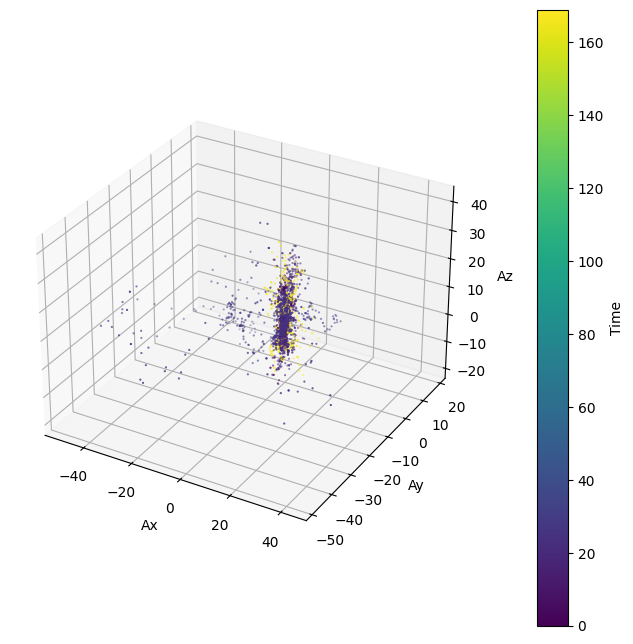

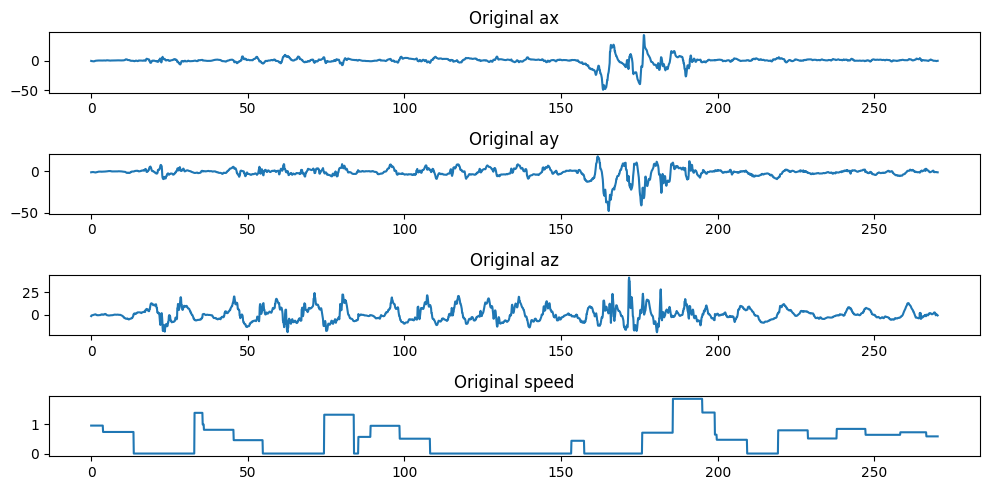

In [20]:
fig4 = plt.figure(figsize=(8, 8))
ax = fig4.add_subplot(111, projection='3d')

sc4 = ax.scatter(jump_df['ax'], jump_df['ay'], jump_df['az'], c=jump_df['time'], cmap='viridis',marker='o', s = 0.3)

cbar = plt.colorbar(sc4, ax=ax, pad=0.1)
cbar.set_label('Time')

ax.set_xlabel('Ax')
ax.set_ylabel('Ay')
ax.set_zlabel('Az')

plt.show(fig4)

plt.figure(figsize=(10, 5))
selected_columns =jump_df.columns[1:5]
selected_data = jump_df[selected_columns]
x = np.arange(0, len(selected_data) * 0.1, 0.1)

for i, col in enumerate(jump_df.columns[1:5]):
    plt.subplot(4, 1, i+1)
    plt.plot(x, jump_df[col],marker='', linestyle='-')
    plt.title(f'{col}')
    
plt.suptitle('Jump Overview', fontsize=16)
plt.tight_layout()
plt.show()

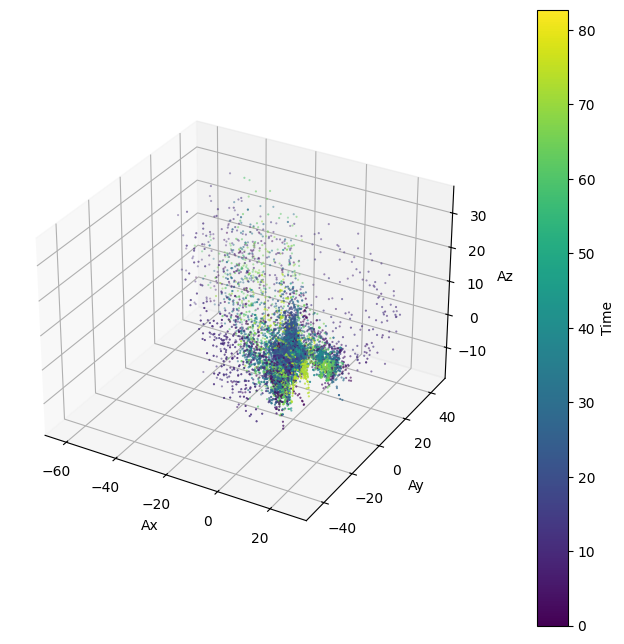

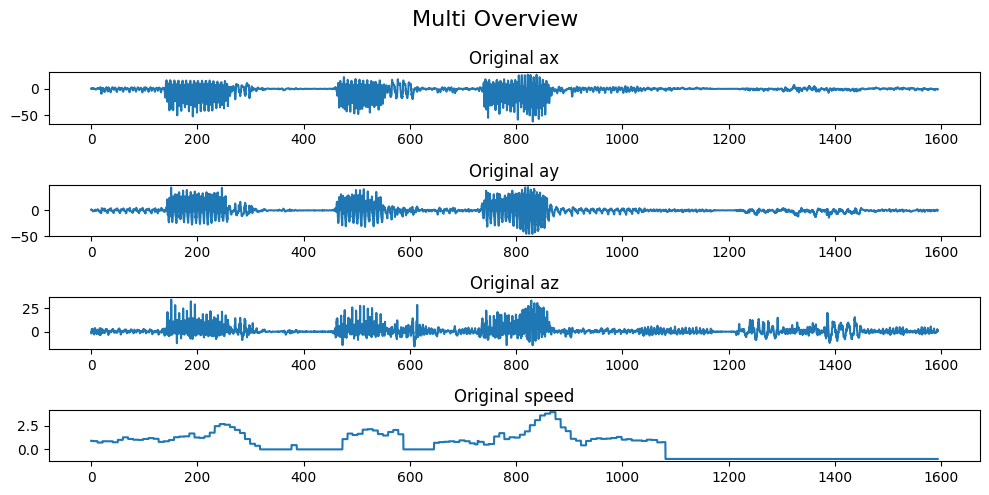

In [30]:
fig5 = plt.figure(figsize=(8, 8))
ax = fig5.add_subplot(111, projection='3d')

sc5 = ax.scatter(multi_df['ax'], multi_df['ay'], multi_df['az'], c=multi_df['time'], cmap='viridis',marker='o', s = 0.3)

cbar = plt.colorbar(sc5, ax=ax, pad=0.1)
cbar.set_label('Time')

ax.set_xlabel('Ax')
ax.set_ylabel('Ay')
ax.set_zlabel('Az')

plt.show(fig5)

plt.figure(figsize=(10, 5))
selected_columns =multi_df.columns[1:5]
selected_data = multi_df[selected_columns]
x = np.arange(0, len(selected_data) * 0.1 -0.1, 0.1)

for i, col in enumerate(multi_df.columns[1:5]):
    plt.subplot(4, 1, i+1)
    plt.plot(x, multi_df[col],marker='', linestyle='-')
    plt.title(f'{col}')
    
plt.suptitle('Multi Overview', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
dfs_combined = pd.concat([run_df, walk_df, jump_df, still_df, multi_df], ignore_index=True)
X = dfs_combined[['time','ax','ay','az','speed']]

le = LabelEncoder()
y = le.fit_transform(dfs_combined['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# FFT denoising

## Data Smoothing

C:\Users\lhg45\AppData\Local\Temp\ipykernel_20200\3785972064.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(run_df['time'], run_loess_smoothed[:, 1], 'r-', label='LOWESS', color='red')
C:\Users\lhg45\AppData\Local\Temp\ipykernel_20200\3785972064.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(walk_df['time'], walk_loess_smoothed[:, 1], 'r-', label='LOWESS', color='blue')
C:\Users\lhg45\AppData\Local\Temp\ipykernel_20200\3785972064.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(jump_df['time'], jump_loess_smoothed[:, 1], 'r-', label='LOWESS', color='green')
C:\Users\lhg45\AppData\Local\Temp\ipykernel_20200\3785

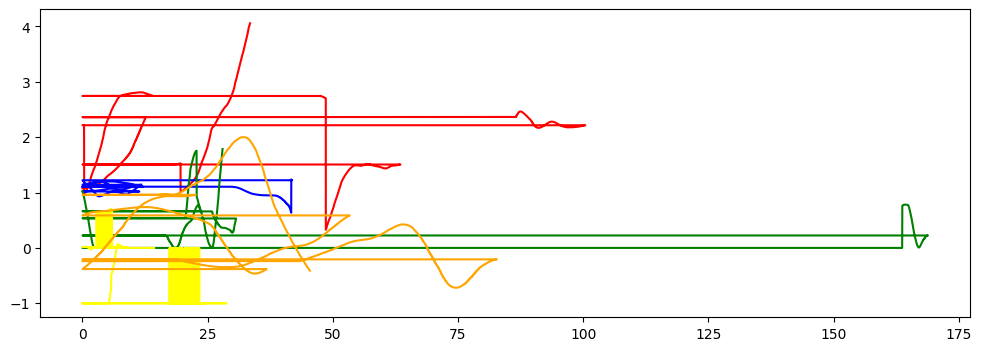

In [ ]:
'''
#Smooth User speed over time for entire list of dataframe
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pykalman import KalmanFilter
lowess = sm.nonparametric.lowess

#Output graph of smoothed speed over time
plt.figure(figsize=(12, 4))
run_loess_smoothed = lowess(run_df['speed'], run_df['time'], frac=0.085)
walk_loess_smoothed = lowess(walk_df['speed'], walk_df['time'], frac=0.085)
jump_loess_smoothed = lowess(jump_df['speed'], jump_df['time'], frac=0.085)
still_loess_smoothed = lowess(still_df['speed'], still_df['time'], frac=0.085)
multi_loess_smoothed = lowess(multi_df['speed'], multi_df['time'], frac=0.085)

#Output plot
#plt.plot(file['time'], file['speed'], 'b.', alpha=0.5, label='Raw Data')
plt.plot(run_df['time'], run_loess_smoothed[:, 1], 'r-', label='LOWESS', color='red')
plt.plot(walk_df['time'], walk_loess_smoothed[:, 1], 'r-', label='LOWESS', color='blue')
plt.plot(jump_df['time'], jump_loess_smoothed[:, 1], 'r-', label='LOWESS', color='green')
plt.plot(still_df['time'], still_loess_smoothed[:, 1], 'r-', label='LOWESS', color='yellow')
plt.plot(multi_df['time'], multi_loess_smoothed[:, 1], 'r-', label='LOWESS', color='orange')
plt.show()
'''

# Training + Scaler

In [ ]:
#scaler = StandardScaler()
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## MLP

Accuracy: 0.9290

Confusion Matrix:


C:\Users\lhg45\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


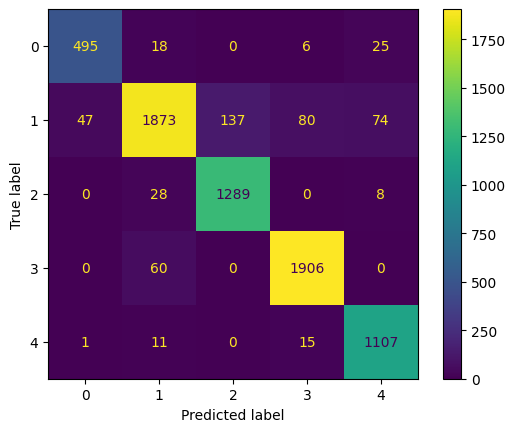

In [ ]:
model_nn = MLPClassifier(
        solver = 'adam', hidden_layer_sizes=(16,32,64,128), activation='relu'
    )

model_nn.fit(X_train_scaled, y_train)
y_pred_nn = model_nn.predict(X_test_scaled)

# Evaluate the model
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f"Accuracy: {accuracy_nn:.4f}")

# Print confusion matrix

print("\nConfusion Matrix:")
#print(confusion_matrix(y_test, y_pred_nn))
cm = confusion_matrix(y_test, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

## Gaussian Naive Bayes

In [ ]:
model_NB =  GaussianNB()
model_NB.fit(X_train_scaled, y_train)
y_pred_NB = model_NB.predict(X_test_scaled)

# Evaluate the model
accuracy_NB = accuracy_score(y_test, y_pred_NB)
print(f"Accuracy: {accuracy_NB:.4f}")

print("\nConfusion Matrix:")
#print(confusion_matrix(y_test, y_pred_NB))
cm = confusion_matrix(y_test, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

Accuracy: 0.64

Confusion Matrix:
[[ 184  123   14   15  192]
 [ 147 1154  328  140  399]
 [  15  575  732    0   39]
 [   0    0    0  494   18]
 [   0   28   30    4 1075]]


## K-Nearest Neighbors Classifier

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=10)
model_knn.fit(X_train_scaled, y_train)
y_pred_knn = model_knn.predict(X_test_scaled)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {accuracy_knn:.4f}")

# Confusion matrix
print("\nConfusion Matrix:")
#print(confusion_matrix(y_test, y_pred_knn))
cm = confusion_matrix(y_test, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

Accuracy: 0.92

Confusion Matrix:
[[ 487   21    5    8    7]
 [  28 1972  124    6   38]
 [   9  140 1200    1   11]
 [   0   15    0  497    0]
 [   6   15    1    1 1114]]


## Random Forest Classifier

In [ ]:
model_RF = RandomForestClassifier(n_estimators=150, random_state=42)

model_RF.fit(X_train_scaled, y_train)
y_pred_RF = model_RF.predict(X_test_scaled)

# Evaluate the model
accuracy_RF = accuracy_score(y_test, y_pred_RF)
print(f"Accuracy: {accuracy_RF:.4f}")

# Print confusion matrix

print("\nConfusion Matrix:")
#print(confusion_matrix(y_test, y_pred_RF))
cm = confusion_matrix(y_test, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

Accuracy: 0.9972

Confusion Matrix:
[[ 524    0    0    2    2]
 [   4 2161    1    2    0]
 [   0    0 1360    0    1]
 [   0    4    0  508    0]
 [   0    0    0    0 1137]]
